## Tutorial - Measuring sensitivity of hyperparameter choice

This tutorial demonstrates how one can use the library to measure to what extent the outcome of evaluation is sensitive to the choice of hyperparameters e.g., choice of baseline value to mask an image with, patch sizes or number of runs. We use a LeNet model and CIFAR-10 dataset to showcase the library's functionality and test the Faithfulness Correlation by Bhatt et al., 2020.



In [1]:
# Mount Google Drive. #remove
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Install packages. #remove
!pip install captum opencv-python
! pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111  -f https://download.pytorch.org/whl/torch_stable.html

# Imports general.
import sys
import warnings
import gc
import cv2
import glob
import pathlib
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import captum
from torchvision import transforms
from tqdm import tqdm
from captum.attr import *
import random

# Import package.
sys.path.append('/content/drive/MyDrive/Projects/xai_quantification_toolbox')
import quantus

# Notebook settings.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
warnings.filterwarnings("ignore", category=UserWarning)
%load_ext autoreload
%autoreload 2

# Collect garbage.
gc.collect()
torch.cuda.empty_cache()

Mounted at /content/drive
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████▌                  | 834.1 MB 1.4 MB/s eta 0:13:30tcmalloc: large alloc 1147494400 bytes == 0x5654b4ce4000 @  0x7ff7ff220615 0x56547b8f54cc 0x56547b9d547a 0x56547b8f82ed 0x56547b9e9e1d 0x56547b96be99 0x56547b9669ee 0x56547b8f9bda 0x56547b96bd00 0x56547b9669ee 0x56547b8f9bda 0x56547b968737 0x56547b9eac66 0x56547b967daf 0x56547b9eac66 0x56547b967daf 0x56547b9eac66 0x56547b967daf 0x56547b8fa039 0x56547b93d409 0x56547b8f8c52 0x56547b96bc25 0x56547b9669ee 0x56547b8f9bda 0x56547b968737 0x56547b9669ee 0x56547b8f9bda 0x56547b967915 0x56547b8f9afa 0x56547b967c0d 0x56547b9669ee
     |█████████████████               | 1055.7 MB 1.3 MB/s eta 0:11:48tcmalloc: large alloc 1434370048 bytes == 0x5654f933a000 @  0x7ff7ff220615 0x56547b8f54cc 0x56547b9d547a 0x56547b8f82ed 0x56547b9e9e1d 0x56547b96be99 0x56547b9669ee 0x56547b8f9bda 0x56547b96bd00 0x56547b9669ee 0x56547b8f9bda 0x56547b968737 0

### Load CIFAR10 dataset.

In [2]:
# Load datasets and make loaders.
transformer = torchvision.transforms.ToTensor()
train_set = torchvision.datasets.CIFAR10(root='./sample_data', train=True, transform=transformer, download=True)
test_set = torchvision.datasets.CIFAR10(root='./sample_data', train=False, transform=transformer, download=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, pin_memory=True) # num_workers=4,
test_loader = torch.utils.data.DataLoader(test_set, batch_size=12, pin_memory=True)

# Load a batch of inputs and outputs to use for evaluation.
x_batch, y_batch = iter(test_loader).next()
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

Files already downloaded and verified
Files already downloaded and verified


### Train a LeNet model.

(or any other model of choice). Network architecture and training procedure is partly copied from: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py.

In [3]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_1 = torch.nn.Conv2d(3, 6, 5)
        self.pool_1 = torch.nn.MaxPool2d(2, 2)
        self.pool_2 = torch.nn.MaxPool2d(2, 2)
        self.conv_2 = torch.nn.Conv2d(6, 16, 5)
        self.fc_1 = torch.nn.Linear(16 * 5 * 5, 120)
        self.fc_2 = torch.nn.Linear(120, 84)
        self.fc_3 = torch.nn.Linear(84, 10)
        self.relu_1 = torch.nn.ReLU()
        self.relu_2 = torch.nn.ReLU()
        self.relu_3 = torch.nn.ReLU()
        self.relu_4 = torch.nn.ReLU()

    def forward(self, x):
        x = self.pool_1(self.relu_1(self.conv_1(x)))
        x = self.pool_2(self.relu_2(self.conv_2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu_3(self.fc_1(x))
        x = self.relu_4(self.fc_2(x))
        x = self.fc_3(x)
        return x


# Load model architecture.
model = Net()
print(f"\n Model architecture: {model.eval()}\n")


 Model architecture: Net(
  (conv_1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc_1): Linear(in_features=400, out_features=120, bias=True)
  (fc_2): Linear(in_features=120, out_features=84, bias=True)
  (fc_3): Linear(in_features=84, out_features=10, bias=True)
  (relu_1): ReLU()
  (relu_2): ReLU()
  (relu_3): ReLU()
  (relu_4): ReLU()
)



In [11]:
def train_model(model, 
                train_data: torchvision.datasets,
                test_data: torchvision.datasets, 
                device: torch.device, 
                epochs: int = 20,
                criterion: torch.nn = torch.nn.CrossEntropyLoss(), 
                optimizer: torch.optim =torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9), 
                evaluate: bool = False):
    """Train torch model."""
    
    model.train()
    
    for epoch in range(epochs):
        for images, labels in train_data:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)

            loss = criterion(logits, labels)
            model.zero_grad()
            loss.backward()
            optimizer.step()

            # Evaluate model!
            predictions, labels = evaluate_model(model, test_data, device)
            test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())
        
        print(f"Epoch {epoch+1}/{epochs} - test accuracy: {(100 * test_acc):.2f}%")

    return model

def evaluate_model(model, data, device):
    """Evaluate torch model."""
    model.eval()
    logits = torch.Tensor().to(device)
    targets = torch.LongTensor().to(device)

    with torch.no_grad():
        for images, labels in data:
            images, labels = images.to(device), labels.to(device)
            logits = torch.cat([logits, model(images)])
            targets = torch.cat([targets, labels])
    
    return torch.nn.functional.softmax(logits, dim=1), targets

In [23]:
path_model_weights = "drive/MyDrive/Projects/xai_quantification_toolbox/tutorials/assets/cifar10"


if pathlib.Path(path_model_weights).is_file():
    model.load_state_dict(torch.load(path_model_weights))
    
else:
    
    # Train and evaluate model.
    model = train_model(model=model.to(device),
                        train_data=train_loader,
                        test_data=test_loader,
                        device=device,
                        epochs=20,
                        criterion=torch.nn.CrossEntropyLoss().to(device),
                        optimizer=torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9),
                        evaluate=True)
    
    # Save model.
    torch.save(model.state_dict(), path_model_weights)

# Model to GPU and eval mode.
model.to(device)
model.eval()

# Check test set performance.
predictions, labels = evaluate_model(model, test_loader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Model test accuracy: {(100 * test_acc):.2f}%")

Model test accuracy: 62.75%


### Load gradient-based attributions.

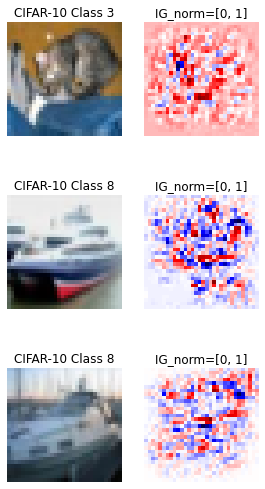

In [41]:
# Load attributions and plot them. 
a_batch = quantus.explain(model, 
                          x_batch, 
                          y_batch, 
                          method="IntegratedGradients",
                          **{"normalize": True})

# Plot examplary explanations!

# Plot examplary inputs!

nr_images = 3
fig, axes = plt.subplots(nrows=nr_images, ncols=2, figsize=(nr_images*1.5, int(nr_images*3)))
for i in range(nr_images):
    axes[i, 0].imshow(np.moveaxis(np.clip(x_batch[i].cpu().numpy(), 0, 1), 0, -1), 
                   vmin=0.0, vmax=1.0)
    axes[i, 0].title.set_text(f"CIFAR-10 Class {y_batch[i]}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(a_batch[i], cmap="seismic")
    axes[i, 1].title.set_text(f"IG_norm=[0, 1]")
    axes[i, 1].axis("off")
plt.show()


### Meaure sensitivity of hyperparameter choice.

We want to understand how sensitive the evaluation outome of Faithfulness Correlation (Bhatt et al., 2020) is from its hyperparameters.

In [49]:
# Let's list the default parameters of the metric.
metric = quantus.FaithfulnessCorrelation()
metric.list_hyperparameters

{'abs': True,
 'default_plot_func': typing.Callable,
 'normalize': True,
 'normalize_func': <function quantus.helpers.normalize_func.normalize_by_max>,
 'nr_runs': 100,
 'perturb_baseline': 'black',
 'perturb_func': <function quantus.helpers.perturb_func.baseline_replacement_by_indices>,
 'similarity_func': <function quantus.helpers.similar_func.correlation_pearson>,
 'subset_size': 224,
 'text_warning': "\nThe Faithfulness correlation metric is known to be sensitive to the choice of baseline value 'perturb_baseline', size of subset |S| 'subset_size' and the number of runs (for each input and explanation pair) 'nr_runs'. Go over and select each hyperparameter of the SelectivityN metric carefully to avoid misinterpretation of scores. To view all relevant hyperparameters call .list_hyperparameters method. For further reading, please see [CITATION].\n"}

In [58]:
# Define some parameter settings to evaluate.
baseline_strategies = ["mean", "random", "uniform", "black", "white"]
subset_sizes = np.arange(2, 12, 2)

# Recompute some Salieny explanations.
a_batch = Saliency(model).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()

# Metric class expects numpy arrays.
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

In [71]:
# Reinitalise the metric and then do a model call (in a one-liner!) while including the different tunable parameters.
results = {
    s: {b: np.mean(quantus.FaithfulnessCorrelation({'abs': True,
                                                    'normalize': True,
                                                    'normalize_func': quantus.normalize_by_max,
                                                    'nr_runs': 100,
                                                    'perturb_baseline': 'black',
                                                    'perturb_func': quantus.baseline_replacement_by_indices,
                                                    'similarity_func': quantus.correlation_pearson,
                                                    'subset_size': 224,})(model=model.cuda(), 
                                                                        x_batch=x_batch, 
                                                                        y_batch=y_batch,
                                                                        a_batch=a_batch,
                                                                        **{"device": device}))
    for b in baseline_strategies}
    for s in subset_sizes
}

In [72]:
# Summarise in a dataframe.      
df = pd.DataFrame(results)
df

,2,4,6,8,10
mean,-0.021149,-0.031660,-0.019194,0.045969,0.007464
random,0.009497,0.013829,0.032538,0.020282,0.042334
uniform,0.011428,0.046574,-0.047009,0.005591,-0.010943
black,0.020539,0.004676,0.024044,0.067885,0.038609
white,0.023554,0.021603,-0.008947,0.069938,-0.029564


In [94]:
# Inspect the standard deviation of faithfulness scores - when it comes to baselines.
print(f"Standard deviation: {df.std(axis=1).mean():.2f}\n{df.std(axis=1)}")

Standard deviation: 0.03
mean       0.031297
random     0.013567
uniform    0.034111
black      0.023817
white      0.037729
dtype: float64


In [93]:
# Inspect the standard deviation of faithfulness scores - when it comes to subset sizes.
print(f"Standard deviation: {df.std(axis=0).mean():.2f}\n{df.std(axis=0)}")

Standard deviation: 0.03
2     0.017747
4     0.028486
6     0.032505
8     0.028564
10    0.031118
dtype: float64


In [87]:
# Let's next investigate how often the ranking between two explanation methods (which one sores highest) changes as we evaluate with the same
# evaluation technique albeit with slightly different hyperparameter settings.
# (our hope is here, that the metric is "stable" enough to propose one explanation method as better - independent of the evaluation settings!)

a_batch_ig = IntegratedGradients(model.to(device)).attribute(inputs=torch.Tensor((x_batch)).to(device), 
                                                             target=torch.LongTensor(y_batch).to(device), 
                                                             baselines=torch.zeros_like(torch.Tensor(x_batch)).to(device), 
                                                             n_steps=10, 
                                                             method="riemann_trapezoid").sum(axis=1).cpu().numpy()

In [95]:
# Reinitalise the metric with Integrated Gradients explanations.
results_ig = {
    s: {b: np.mean(quantus.FaithfulnessCorrelation({'abs': True,
                                                    'normalize': True,
                                                    'normalize_func': quantus.normalize_by_max,
                                                    'nr_runs': 100,
                                                    'perturb_baseline': 'black',
                                                    'perturb_func': quantus.baseline_replacement_by_indices,
                                                    'similarity_func': quantus.correlation_pearson,
                                                    'subset_size': 224,})(model=model.cuda(), 
                                                                        x_batch=x_batch, 
                                                                        y_batch=y_batch,
                                                                        a_batch=a_batch_ig,
                                                                        **{"device": device}))
    for b in baseline_strategies}
    for s in subset_sizes
}

In [97]:
# Summarise in a dataframe.      
df_ig = pd.DataFrame(results_ig)
df_ig

,2,4,6,8,10
mean,0.073337,0.107471,0.076047,0.076517,0.047498
random,0.035088,0.105757,0.054486,0.072533,0.079860
uniform,0.081219,0.089881,0.068417,0.026974,0.076660
black,0.145343,0.029516,0.075072,0.101745,0.094677
white,0.063980,0.093193,0.087830,0.041886,0.045930


In [111]:
# How often is faithfulness correlation of Integrated Gradient explanations higher than that of Saliency explanations
print(f"{np.array([np.greater(b, a) for i, ig in zip(df.to_numpy(), df_ig.to_numpy()) for a, b in zip(i, ig)]).astype(int).mean()*100:.1f}% of the times.")

96.0% of the times.
